In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
import pandas as pd
import theano
import arviz as az

from scipy import stats
import xarray as xr

import itertools
from theano import tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv("./IMA_recommendation_simulation_data.csv")
data = data.dropna()

In [3]:
def zz(value):
    if value < 100:
        return 'Z0'
    elif value < 200:
        return 'Z1'
    elif value < 300:
        return 'Z2'
    elif value < 400:
        return 'Z3'
    elif value < 500:
        return 'Z4'
    elif value < 600:
        return 'Z5'
    elif value < 700:
        return 'Z6'
    elif value < 800:
        return 'Z7'
    elif value < 900:
        return 'Z8'
    elif value < 1000:
        return 'Z9'
    else:
        return 'Error'


data['ZipZone_origin'] = data.apply(lambda column: zz(column['origin_dat_ref']),axis=1)
data['ZipZone_dest'] = data.apply(lambda column: zz(column['dest_dat_ref']),axis=1)

In [4]:
data = data[data['lead_days'] >= 0]

#data[(data['ZipZone_origin'] == 'Z3')&(data['ZipZone_dest'])=='Z3']

In [5]:
data['order_distance_norm'] = (data['order_distance'] - data['order_distance'].mean())/(data['order_distance'].std())
data['weight_norm'] = (data['order_origin_weight'] - data['order_origin_weight'].mean())/(data['order_origin_weight'].std())
data['lead_days_norm'] = (data['lead_days'] - data['lead_days'].mean())/(data['lead_days'].std())

In [6]:
from sklearn.preprocessing import LabelEncoder

sch_le = LabelEncoder()

zipzone = sch_le.fit_transform(data['ZipZone_origin'])
n_zipzones = len(sch_le.classes_)
order_distance_norm = data.order_distance_norm
weight_norm = data.weight_norm
lead_days_norm = data.lead_days_norm
rate_norm = data.rate_norm
est_cost_norm = data.est_cost_norm

order_distance_norm = np.array(order_distance_norm.values.tolist())
weight_norm = np.array(weight_norm.values.tolist())
lead_days_norm = np.array(lead_days_norm.values.tolist())
rate_norm = np.array(rate_norm.values.tolist())
est_cost_norm = np.array(est_cost_norm.tolist())

## Pooled Models for rate_norm and est_cost_norm in terms of order_distance, order_origin_weight, and lead_days

In [8]:
with pm.Model() as rate_model_2:
    x1_shared = pm.Data("distance", order_distance_norm)
    x2_shared = pm.Data("weight", weight_norm)
    x3_shared = pm.Data("leaddays", lead_days_norm)
    y_shared = pm.Data("rate", rate_norm)
    
    # Hyperpriors
    mu_intercept = pm.Normal('mu_intercept', mu=-1, sigma=1)
    sigma_intercept = pm.Exponential('sigma_intercept', 1) # Possibly change these sigma distributions (Normal doesn't work)
    
    mu_distance = pm.Normal('mu_distance', mu=0, sigma=1)
    sigma_distance = pm.Exponential('sigma_distance', 1)
    
    mu_weight = pm.Normal('mu_weight', mu=0, sigma=1)
    sigma_weight = pm.Exponential('sigma_weight', 1)
    
    mu_leaddays = pm.Normal('mu_leaddays', mu=0, sigma=1)
    sigma_leaddays = pm.Exponential('sigma_leaddays', 1)
    
    # Intercept Prior
    intercept = pm.Normal('intercept', mu=mu_intercept, sigma=sigma_intercept)
    # order_distance_norm Coefficient Prior
    distance_coef = pm.Normal('distance_coef', mu=mu_distance, sigma=sigma_distance)
    # weight_norm Coefficient Prior
    weight_coef = pm.Normal('weight_coef', mu=mu_weight, sigma=sigma_weight)
    # lead_days_norm Coefficient Prior
    leaddays_coef = pm.Normal('leaddays_coef', mu=mu_leaddays, sigma=sigma_leaddays)
    
    # Model error
    epsilon = pm.HalfNormal('epsilon', 1) # Possibly change distribution
    
    y_hat = intercept + distance_coef * x1_shared + weight_coef * x2_shared + leaddays_coef * x3_shared
    
    # Likelihood
    pm.Normal('y_like', mu=y_hat, sigma=epsilon, observed=y_shared) # Could try changing the normal distribution
    
    rate_trace_2 = pm.sample(1000, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, leaddays_coef, weight_coef, distance_coef, intercept, sigma_leaddays, mu_leaddays, sigma_weight, mu_weight, sigma_distance, mu_distance, sigma_intercept, mu_intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 770 seconds.
There were 309 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6781352531265888, but should be close to 0.8. Try to increase the number of tuning steps.
There were 302 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5899243563762534, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
summary = az.summary(rate_trace_2, round_to=8)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_intercept,-0.370740,0.630556,-1.695207,0.658913,0.037489,0.026536,282.904908,282.904908,307.324762,484.403950,1.008857
mu_distance,0.437982,0.598474,-0.884860,1.350054,0.064254,0.045588,86.755135,86.755135,124.193815,26.460161,1.017759
mu_weight,0.018582,0.555512,-1.068272,1.155751,0.033709,0.026895,271.580090,213.888319,254.542155,245.926494,1.015265
mu_leaddays,-0.038267,0.605820,-1.202772,1.220801,0.034966,0.024749,300.185026,300.185026,276.081136,181.829160,1.007393
intercept,-0.010161,0.001738,-0.013399,-0.006526,0.000081,0.000058,460.696139,444.318872,446.093403,307.116259,1.031954
distance_coef,0.681563,0.001816,0.678187,0.684816,0.000153,0.000109,140.327267,140.085666,151.817014,219.927385,1.007575
weight_coef,-0.002014,0.001852,-0.005317,0.001404,0.000103,0.000080,323.831842,270.742069,335.558528,557.750835,1.003218
leaddays_coef,-0.027946,0.001813,-0.031195,-0.024698,0.000153,0.000109,140.025213,138.380976,164.782592,412.407142,1.029284
sigma_intercept,0.867820,0.872068,0.045554,2.405898,0.083489,0.059194,109.104292,109.104292,62.165781,22.686817,1.014132
sigma_distance,0.754001,0.740739,0.047323,1.997624,0.046455,0.032887,254.247339,254.247339,82.213022,46.120648,1.016054


<ipython-input-10-b5ea0f9c3eca>:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(rate_trace_2)


array([[<AxesSubplot:title={'center':'mu_intercept'}>,
        <AxesSubplot:title={'center':'mu_intercept'}>],
       [<AxesSubplot:title={'center':'mu_distance'}>,
        <AxesSubplot:title={'center':'mu_distance'}>],
       [<AxesSubplot:title={'center':'mu_weight'}>,
        <AxesSubplot:title={'center':'mu_weight'}>],
       [<AxesSubplot:title={'center':'mu_leaddays'}>,
        <AxesSubplot:title={'center':'mu_leaddays'}>],
       [<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'distance_coef'}>,
        <AxesSubplot:title={'center':'distance_coef'}>],
       [<AxesSubplot:title={'center':'weight_coef'}>,
        <AxesSubplot:title={'center':'weight_coef'}>],
       [<AxesSubplot:title={'center':'leaddays_coef'}>,
        <AxesSubplot:title={'center':'leaddays_coef'}>],
       [<AxesSubplot:title={'center':'sigma_intercept'}>,
        <AxesSubplot:title={'center':'sigma_intercept'}>],
       [<

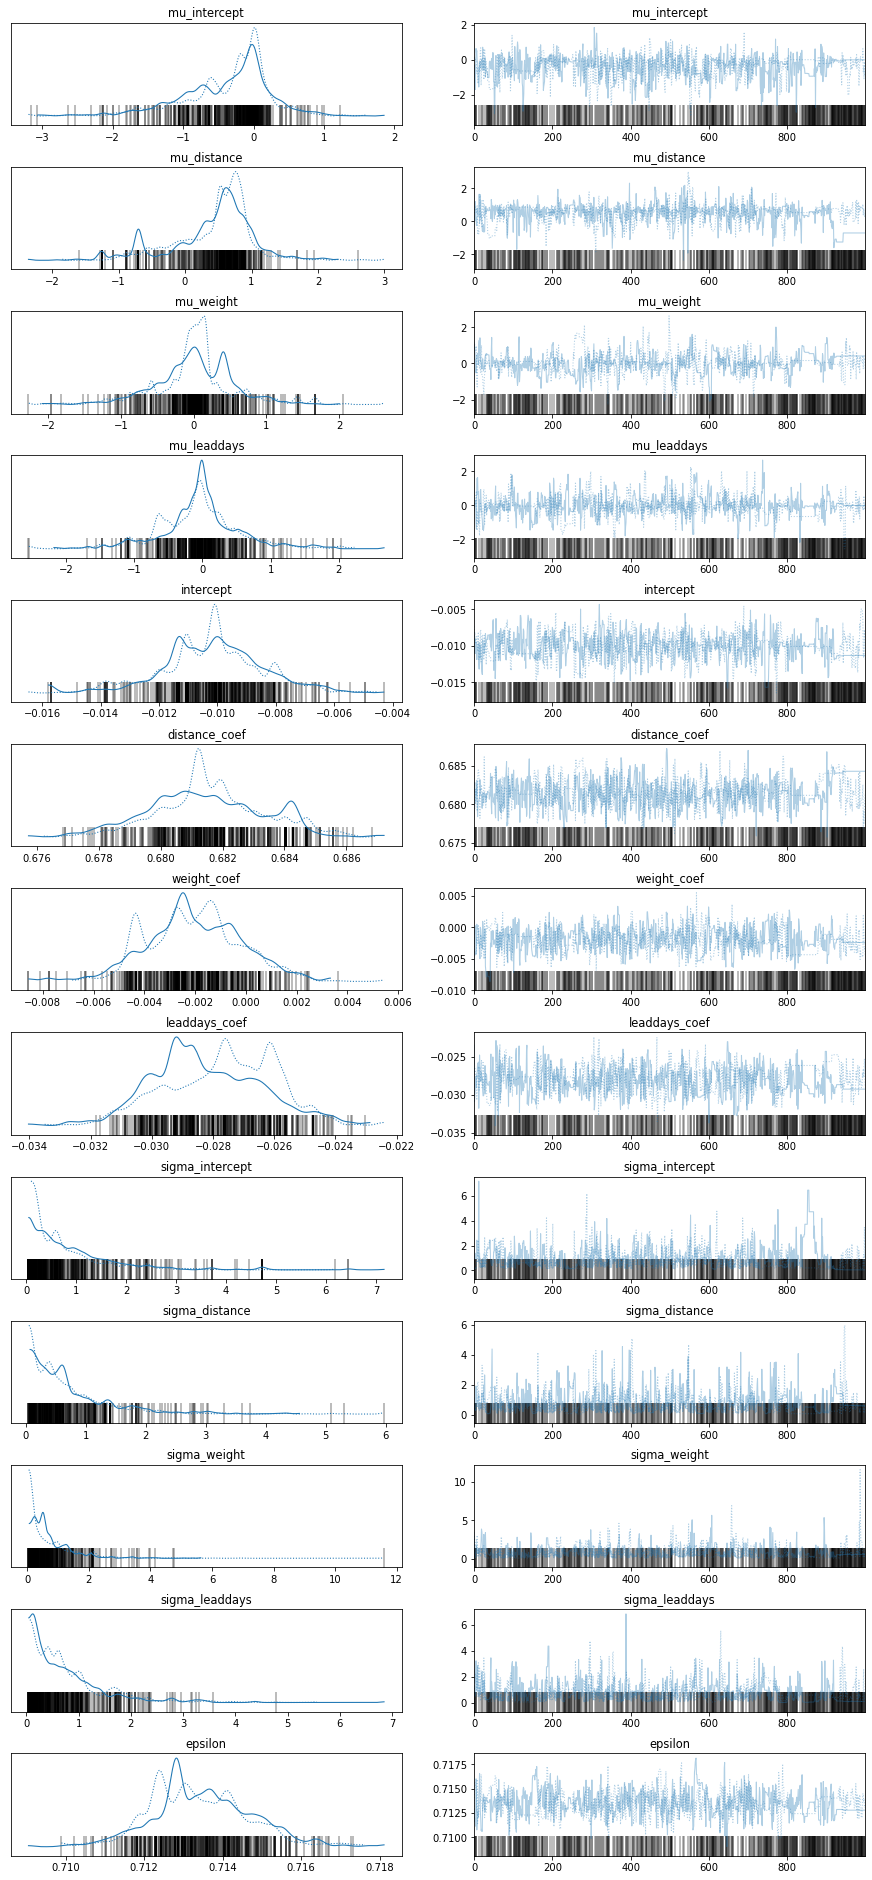

In [10]:
from pymc3 import traceplot

traceplot(rate_trace_2)

In [ ]:
#az.plot_ppc(az.from_pymc3(posterior_predictive=cost_post_pred_11, model=cost_model_1))

In [11]:
with pm.Model() as cost_model_2:
    x1_shared = pm.Data("distance", order_distance_norm)
    x2_shared = pm.Data("weight", weight_norm)
    x3_shared = pm.Data("leaddays", lead_days_norm)
    y_shared = pm.Data("cost", est_cost_norm)
    
    # Hyperpriors
    mu_intercept = pm.Normal('mu_intercept', mu=-1, sigma=1)
    sigma_intercept = pm.Exponential('sigma_intercept', 1) # Possibly change these sigma distributions (Normal doesn't work)

    mu_distance = pm.Normal('mu_distance', mu=0, sigma=1)
    sigma_distance = pm.Exponential('sigma_distance', 1)
    
    mu_weight = pm.Normal('mu_weight', mu=0, sigma=1)
    sigma_weight = pm.Exponential('sigma_weight', 1)
    
    mu_leaddays = pm.Normal('mu_leaddays', mu=0, sigma=1)
    sigma_leaddays = pm.Exponential('sigma_leaddays', 1)
    
    # Intercept Prior
    intercept = pm.Normal('intercept', mu=mu_intercept, sigma=sigma_intercept)
    # order_distance_norm Coefficient Prior
    distance_coef = pm.Normal('distance_coef', mu=mu_distance, sigma=sigma_distance)
    # weight_norm Coefficient Prior
    weight_coef = pm.Normal('weight_coef', mu=mu_weight, sigma=sigma_weight)
    # lead_days_norm Coefficient Prior
    leaddays_coef = pm.Normal('leaddays_coef', mu=mu_leaddays, sigma=sigma_leaddays)
    
    # Model error
    epsilon = pm.HalfNormal('epsilon', 1) # Possibly change distribution
    
    y_hat = intercept + distance_coef * x1_shared + weight_coef * x2_shared + leaddays_coef * x3_shared
    
    # Likelihood
    pm.Normal('y_like', mu=y_hat, sigma=epsilon, observed=y_shared)
    
    cost_trace_2 = pm.sample(1000, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, leaddays_coef, weight_coef, distance_coef, intercept, sigma_leaddays, mu_leaddays, sigma_weight, mu_weight, sigma_distance, mu_distance, sigma_intercept, mu_intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 813 seconds.
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7077054827502622, but should be close to 0.8. Try to increase the number of tuning steps.
There were 353 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5883808780725666, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
summary = az.summary(cost_trace_2, round_to=8)
summary

In [ ]:
from pymc3 import traceplot

traceplot(cost_trace_2)